## OpenAI의 Gym

- **Gym**이란 강화학습 알고리즘을 개발하고 실험하기 위한 **시뮬레이션 환경 모음**이다.  
- 주로 파이썬 기반

In [51]:
!pip install numpy==1.23.5

In [52]:
!pip install gym

In [53]:
import numpy as np
import gym
import random

### 1. Create taxi environment

- Taxi enviroment is 5x5 gridworld.
- Location of taxi is randomly located in the env square.
- Passenger is randomly located in one of the 4 possible locations (R, G, Y, B) and their destination is one of theses 4 locations as well.
- The reward system:
    - -1 for each timestep
    - +20 for successfully deliver the passenger from the start point to his/her location
    - -10 for illegal actions (pick up or put down the passenger at the wrong location)



In [54]:
env = gym.make("Taxi-v3") # 환경 객체 생성

### 2. Create Q-table and initialize it
- 가능한 상태
    - 택시의 위치 (25개) x 승객의 위치 (5개; 4개의 장소 + 택시 안) x 목적지의 위치 (4개) = 500개
- 가능한 행동
    - 0: 아래로
    - 1: 위로
    - 2: 오른쪽으로
    - 3: 왼쪽으로
    - 4: 승객 태우기
    - 5: 승객 내리기

In [55]:
state_space = env.observation_space.n
print(f"There are {state_space} possible states.")
action_space = env.action_space.n
print(f"There are {action_space} possible actions.")

There are 500 possible states.
There are 6 possible actions.


In [56]:
# create Q-table with state_size rows and action_size columns (500x6)
Q = np.zeros(shape=(state_space, action_space))
print(Q)
print(Q.shape)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
(500, 6)


### 3. Define the hyperparameters

In [75]:
EPISODES = 25000 # 훈련 에피소드
TEST_EPISODES = 100 # 테스트 에피소드
MAX_STEPS = 200 # 한 번의 에피소드에서 최대 타임 스텝

LEARNING_RATE = 0.01 # 학습률 알파
GAMMA = 0.99 # 할인율

EPSILON = 1.0 # 엡실론
MAX_EPSILON = 1.0
MIN_EPSILON = 0.01
DECAY_RATE = 0.01 # 엡실론을 줄일 때 사용하는 하이퍼 파라미터

### 4. Define the epsilon-greedy policy

- with probability of epsilon: action randomly
- with probability of (1-epsilon): action greedy

In [58]:
def epsilon_greedy_policy(Q, state):
    # greedy action -> exploitation
    if (random.uniform(0, 1)>EPSILON):
        action = np.argmax(Q[state])
    # exploration
    else:
        action = env.action_space.sample()
    return action

### 5. Define the Q-learning algorithm and train the agent

- Sample that needs for Q-learning update: (s, a, r, s')
- 5분 정도 걸림

In [60]:
rewards = []
steps = []

for episode in range(EPISODES):
    state = env.reset()
    step = 0
    done = False
    epi_reward = 0
    # 매 에피소드마다 엡실론을 감소시킴
    epsilon = MIN_EPSILON + (MAX_EPSILON-MIN_EPSILON)*np.exp(-DECAY_RATE*episode)
    for step in range(MAX_STEPS):
        # s, a
        action = epsilon_greedy_policy(Q, state)
        # r, s'
        next_state, reward, done, info = env.step(action)
        epi_reward += reward
        # Q-learning update
        # Q(s,a) <- Q(s,a)+lr*[r+gamma*max(Q(s',a'))-Q(s,a)]
        Q[state][action] = Q[state][action]+LEARNING_RATE*(reward+GAMMA*np.max(Q[next_state])-Q[state][action])

        if done == True:
            rewards.append(epi_reward)
            steps.append(step)
            break
        state = next_state

### 6. Watch our autonomous taxi

- 파란색 장소: 승객을 픽업할 장소
- 핑크색 장소: 승객의 목적지
- 택시의 색
    - 택시가 초록색으로 변하면 승객을 태운 상태를 의미
    - 택시가 노란색이면 승객을 태우지 않음을 의미
    - 택시가 파란색이면 승객을 내려줌을 의미

In [76]:
import time
test_rewards = []
test_steps = []

for episode in range(TEST_EPISODES):
    state = env.reset()
    step = 0
    done = False
    epi_reward = 0
    print(f"------EPISODE {episode}------")
    # 테스트에서 엡실론은 항상 0 (랜덤하게 행동하는 것 없이 항상 탐욕 정책을 따름)
    for step in range(MAX_STEPS):
        print(env.render(mode='ansi')) # 상태 render
        action = np.argmax(Q[state]) # 길이가 6인 행동 리스트 하나 반환
        next_state, reward, done, info = env.step(action)
        epi_reward += reward
        if done:
            test_rewards.append(epi_reward)
            test_steps.append(step)
            break
        state = next_state
env.close()

------EPISODE 0------
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

+---------+
|R:_| : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| :_| : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : :_|
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : :_|
| : 

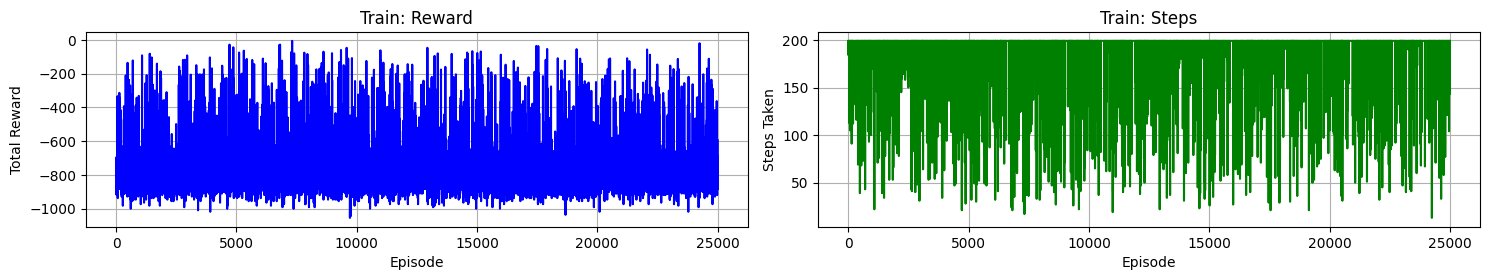

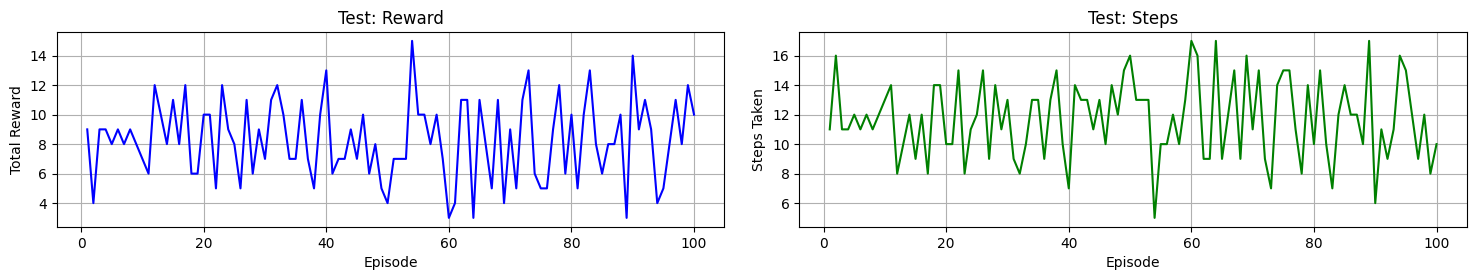

'\ntrain과 test에서 에피소드에 따른 보상, 스텝 수, elapsed time을 시각화한 결과, \nreward는 train에서 0~-1000의 범위를 갖지만 test에선 5~11의 범위를 가짐\nstep은 train에서 50~200의 범위를 갖지만 test에선 9~15의 범위를 가짐\ntime은 train에서 0.00~0.08의 범위를 갖지만 test에선 0.006~0의 범위를 가짐 \n-> 탐욕적으로만 행동하면 태스크를 잘 수행할 수 있다: 학습이 잘 되었다!\n'

In [83]:
# 시각화
import matplotlib.pyplot as plt

# 훈련
episodes = [epi for epi in range(1,EPISODES+1)]
plt.figure(figsize=(15, 5))

# 보상
plt.subplot(2, 2, 1)
plt.plot(episodes, rewards, label='Reward', color='blue')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Train: Reward')
plt.grid(True)

# 스텝 수
plt.subplot(2, 2, 2)
plt.plot(episodes, steps, label='Steps', color='green')
plt.xlabel('Episode')
plt.ylabel('Steps Taken')
plt.title('Train: Steps')
plt.grid(True)

plt.tight_layout()
plt.show()

# 테스트
test_episodes = [epi for epi in range(1,TEST_EPISODES+1)]

plt.figure(figsize=(15, 5))

# 보상
plt.subplot(2, 2, 3)
plt.plot(test_episodes, test_rewards, color='blue')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Test: Reward')
plt.grid(True)

# 스텝 수
plt.subplot(2, 2, 4)
plt.plot(test_episodes, test_steps, color='green')
plt.xlabel('Episode')
plt.ylabel('Steps Taken')
plt.title('Test: Steps')
plt.grid(True)


plt.tight_layout()
plt.show()

'''
train과 test에서 에피소드에 따른 보상, 스텝 수, elapsed time을 시각화한 결과,
reward는 train에서 0~-1000의 범위를 갖지만 test에선 5~11의 범위를 가짐
step은 train에서 50~200의 범위를 갖지만 test에선 9~15의 범위를 가짐
time은 train에서 0.00~0.08의 범위를 갖지만 test에선 0.006~0의 범위를 가짐
-> 탐욕적으로만 행동하면 태스크를 잘 수행할 수 있다: 학습이 잘 되었다!
'''

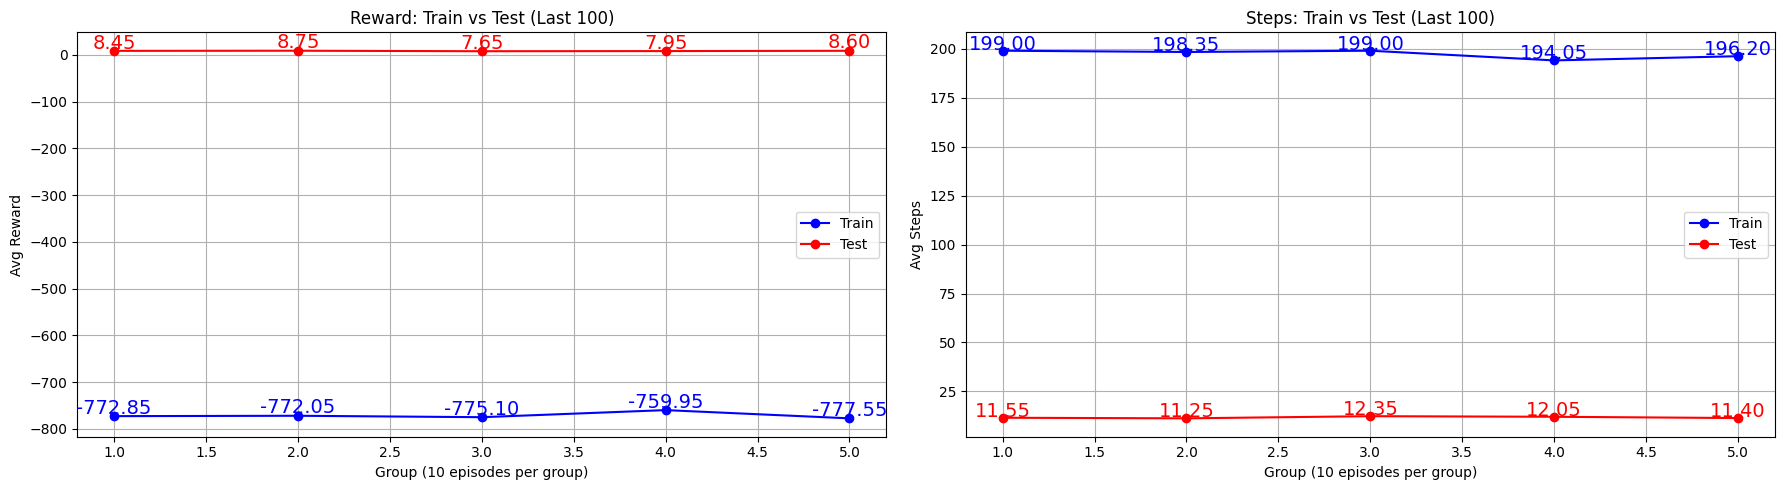

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# 마지막 100개 훈련 샘플 추출
train_rewards_last100 = rewards[-100:]
train_steps_last100 = steps[-100:]

# 그룹 나누기 (10개씩 10그룹)
def group_avg(data, group_size=20):
    return [np.mean(data[i*group_size:(i+1)*group_size]) for i in range(len(data) // group_size)]

# 평균값 계산
train_reward_avg = group_avg(train_rewards_last100)
test_reward_avg = group_avg(test_rewards)

train_step_avg = group_avg(train_steps_last100)
test_step_avg = group_avg(test_steps)

# x축 (그룹 번호: 1~10)
groups = list(range(1, 6))

# 시각화
plt.figure(figsize=(18, 5))

# ---- Reward 비교 ----
plt.subplot(1, 2, 1)
plt.plot(groups, train_reward_avg, marker='o', label='Train', color='blue')
plt.plot(groups, test_reward_avg, marker='o', label='Test', color='red')
for i, (tr, te) in enumerate(zip(train_reward_avg, test_reward_avg)):
    plt.text(groups[i], tr + 5, f'{tr:.2f}', ha='center', fontsize=14, color='blue')
    plt.text(groups[i], te + 5, f'{te:.2f}', ha='center', fontsize=14, color='red')
plt.title('Reward: Train vs Test (Last 100)')
plt.xlabel('Group (10 episodes per group)')
plt.ylabel('Avg Reward')
plt.grid(True)
plt.legend()

# ---- Steps 비교 ----
plt.subplot(1, 2, 2)
plt.plot(groups, train_step_avg, marker='o', label='Train', color='blue')
plt.plot(groups, test_step_avg, marker='o', label='Test', color='red')
for i, (tr, te) in enumerate(zip(train_step_avg, test_step_avg)):
    plt.text(groups[i], tr + 0.5, f'{tr:.2f}', ha='center', fontsize=14, color='blue')
    plt.text(groups[i], te + 0.5, f'{te:.2f}', ha='center', fontsize=14, color='red')
plt.title('Steps: Train vs Test (Last 100)')
plt.xlabel('Group (10 episodes per group)')
plt.ylabel('Avg Steps')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [85]:
print(Q)

[[ 0.          0.          0.          0.          0.          0.        ]
 [ 4.60674803  5.95788636  4.61131234  5.96706524  7.31271949 -3.0473728 ]
 [10.39498724 11.64488731 10.38600066 11.6621591  12.94481687  2.66976236]
 ...
 [13.33281728 14.73870873 13.30633198 11.86894123  4.28836557  4.34091359]
 [ 7.13276455  8.49609457  7.14288354  8.63669499 -1.87826153 -1.89378765]
 [16.84908263 15.44859472 16.82399349 18.51594753  7.87907463  7.86467206]]
